In [ ]:
import pandas as pd
import numpy as np


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download -d grassknoted/asl-alphabet

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
100% 1.02G/1.03G [00:15<00:00, 102MB/s] 
100% 1.03G/1.03G [00:15<00:00, 69.9MB/s]


In [ ]:
!unzip asl-alphabet.zip -d asl-alphabet

Streaming output truncated to the last 5000 lines.
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alp

import zipfile

zip_ref=zipfile.ZipFile('/content/asl-alphabet.zip','r')

zip_ref.extractall('/content')

zip_ref.close()

# Importing neccessary Libraries

In [ ]:
! pip install imutils

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import gc
import string
import time
import random
import imutils
from PIL import Image
from tqdm import tqdm
tqdm.pandas()


In [ ]:
# Visualization Libraries
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



In [ ]:
# Configuration
class CFG:
  batch_size =64
  img_height=64
  img_width = 64
  epochs =10
  num_classes = 29
  img_channels = 3

def seed_everything (seed: int):

  random.seed(seed)

  os.environ ["PYTHONHASHSEED"] = str(seed)

  np.random.seed(seed)

  tf.random.set_seed(seed)

In [ ]:
# Labels

TRAIN_PATH = "/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train"

labels = []

alphabet = list(string.ascii_uppercase)

labels.extend(alphabet)

labels.extend(["del", "nothing", "space"])

print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


# Data Preprocessing

In [ ]:
#Create Metadata

list_path = []

list_labels = []

for label in labels:

  label_path = os.path.join(TRAIN_PATH, label, "*")

  image_files= glob.glob(label_path)

  sign_label= [label]* len(image_files)

  list_path.extend(image_files)

  list_labels.extend(sign_label)

metadata= pd. DataFrame({

  "image_path": list_path,

  "label": list_labels
 })

metadata

,image_path,label
0,/content/asl-alphabet/asl_alphabet_train/asl_a...,A
1,/content/asl-alphabet/asl_alphabet_train/asl_a...,A
2,/content/asl-alphabet/asl_alphabet_train/asl_a...,A
3,/content/asl-alphabet/asl_alphabet_train/asl_a...,A
4,/content/asl-alphabet/asl_alphabet_train/asl_a...,A
...,...,...
86995,/content/asl-alphabet/asl_alphabet_train/asl_a...,space
86996,/content/asl-alphabet/asl_alphabet_train/asl_a...,space
86997,/content/asl-alphabet/asl_alphabet_train/asl_a...,space
86998,/content/asl-alphabet/asl_alphabet_train/asl_a...,space


In [ ]:
# Ensure that the data is split correctly
from sklearn.model_selection import train_test_split
import pandas as pd

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"],
    metadata["label"],
    test_size=0.15,
    random_state=2023,
    shuffle=True,
    stratify=metadata["label"]
)

data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"],
    data_train["label"],
    test_size=0.15 / 0.70,  # Adjusting for validation set
    random_state=2023,
    shuffle=True,
    stratify=data_train["label"]
)

data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})

# Data Augmentation - Just Rescale
def data_augmentation():
    datagen = ImageDataGenerator(rescale=1/255.)

    # Training Dataset
    train_generator = datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width)
    )

    # Validation Dataset
    validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width)
    )

    # Test Dataset
    test_generator = datagen.flow_from_dataframe(
        data_test,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
        shuffle=False  # Typically, you don't shuffle the test data
    )

    return train_generator, validation_generator, test_generator

# Initialize the data generators
train_generator, validation_generator, test_generator = data_augmentation()


Found 58103 validated image filenames belonging to 29 classes.
Found 15847 validated image filenames belonging to 29 classes.
Found 13050 validated image filenames belonging to 29 classes.


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,041,309 (61.19 MB)

 Trainable params: 1,326,621 (5.06 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

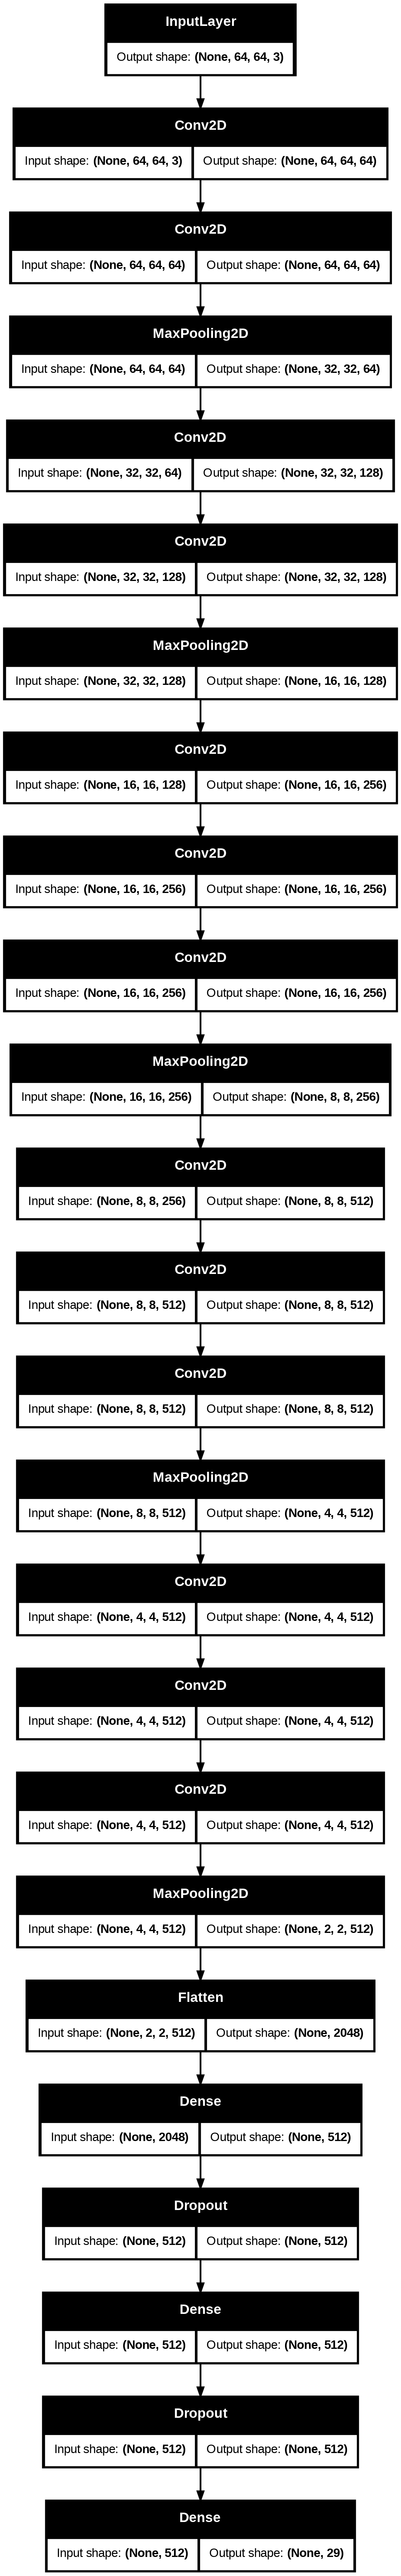

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the VGG16 model with pre-trained ImageNet weights, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(CFG.img_height, CFG.img_width, CFG.img_channels))

# Freeze the layers of the base model to prevent them from being trained
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for ASL recognition
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(CFG.num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Display the model summary
model.summary()

# Display the model architecture as an image
tf.keras.utils.plot_model(model, to_file='vgg16.png', show_shapes=True)


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']  # Added metrics for monitoring performance
)



In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Callbacks
checkpoint = ModelCheckpoint(
    'asl_vgg16_best_weights.keras',  # Changed extension to .keras
    save_best_only=True,
    monitor='val_loss',  # Monitor validation loss to save the best weights
    mode='min',  # Save the model with the minimum validation loss
    verbose=1  # Print messages when saving the model
)




In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // CFG.batch_size,
    epochs=CFG.epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // CFG.batch_size,
    callbacks=[checkpoint]
)

Epoch 1/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4599 - loss: 1.8207
Epoch 1: val_loss improved from inf to 0.22386, saving model to asl_vgg16_best_weights.keras
907/907 ━━━━━━━━━━━━━━━━━━━━ 92s 87ms/step - accuracy: 0.4602 - loss: 1.8199 - val_accuracy: 0.9383 - val_loss: 0.2239
Epoch 2/10
  1/907 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.9062 - loss: 0.2955
Epoch 2: val_loss improved from 0.22386 to 0.20902, saving model to asl_vgg16_best_weights.keras
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9062 - loss: 0.2955 - val_accuracy: 0.9231 - val_loss: 0.2090
Epoch 3/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8482 - loss: 0.4436
Epoch 3: val_loss improved from 0.20902 to 0.11262, saving model to asl_vgg16_best_weights.keras
907/907 ━━━━━━━━━━━━━━━━━━━━ 66s 73ms/step - accuracy: 0.8482 - loss: 0.4435 - val_accuracy: 0.9666 - val_loss: 0.1126
Epoch 4/10
  1/907 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9688 - loss: 0.1458
Epoch 4:

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

# Define custom F1-score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * (precision * recall) / (precision + recall + 1e-7)  # Adding epsilon to avoid division by zero

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# Compile the model with additional metrics
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall(), F1Score()]
)


In [ ]:
from sklearn.metrics import classification_report

# Evaluate the model on the test data
scores = model.evaluate(test_generator)

# Print evaluation results
print(f"Evaluate Test Loss: {scores[0]:.2f}")
print(f"Evaluate Test Accuracy: {scores[1]*100:.2f}%")
print(f"Evaluate Test Precision: {scores[2]:.2f}")
print(f"Evaluate Test Recall: {scores[3]:.2f}")
print(f"Evaluate Test F1 Score: {scores[4]:.2f}")

# Predict labels for the test data
y_pred_probs = model.predict(test_generator)
y_pred = tf.argmax(y_pred_probs, axis=-1).numpy()

# True labels for the test data
y_true = test_generator.classes

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(report)


204/204 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.9801 - f1_score: 0.9803 - loss: 0.0564 - precision: 0.9861 - recall: 0.9746
Evaluate Test Loss: 0.06
Evaluate Test Accuracy: 98.15%
Evaluate Test Precision: 0.99
Evaluate Test Recall: 0.98
Evaluate Test F1 Score: 0.98
204/204 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step
              precision    recall  f1-score   support

           A       0.98      1.00      0.99       450
           B       1.00      1.00      1.00       450
           C       1.00      1.00      1.00       450
           D       0.99      1.00      1.00       450
           E       0.99      0.97      0.98       450
           F       1.00      1.00      1.00       450
           G       1.00      0.96      0.98       450
           H       0.97      0.99      0.98       450
           I       0.99      0.98      0.99       450
           J       0.98      1.00      0.99       450
           K       0.99      0.99      0.99       450
           L       1.00      1.00

Plot of Training-validation

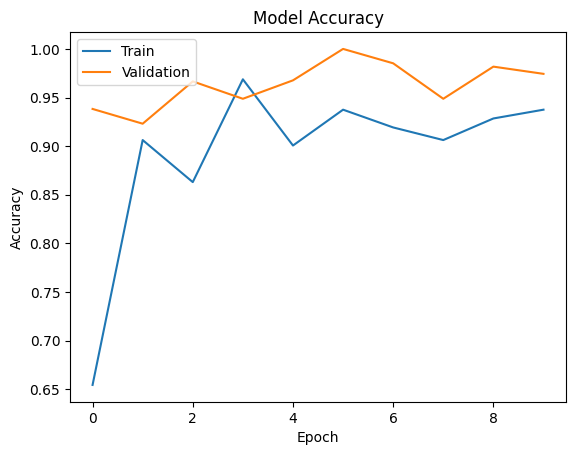

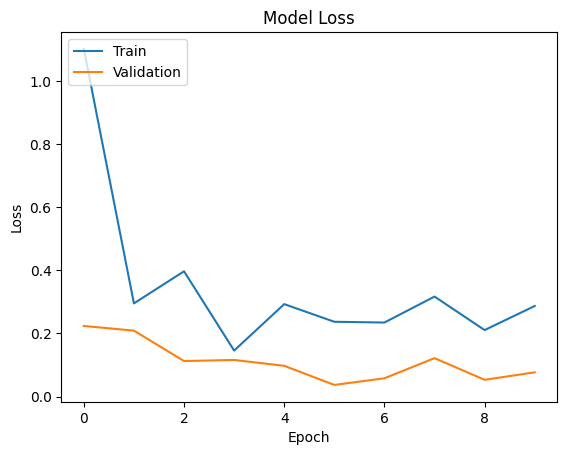

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Confusion Matrix

204/204 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step


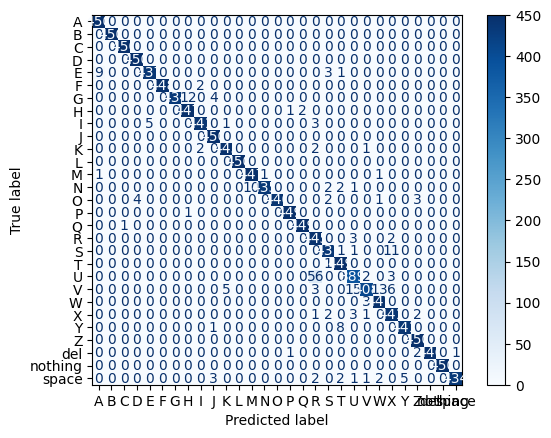

In [ ]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import numpy as np

# # Predict labels for the test data
# y_pred_probs = model.predict(test_generator)
# y_pred = np.argmax(y_pred_probs, axis=-1)

# # True labels for the test data
# y_true = test_generator.classes

# # Compute confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Plot confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
# disp.plot(cmap=plt.cm.Blues)
# plt.show()

plot Classification Report

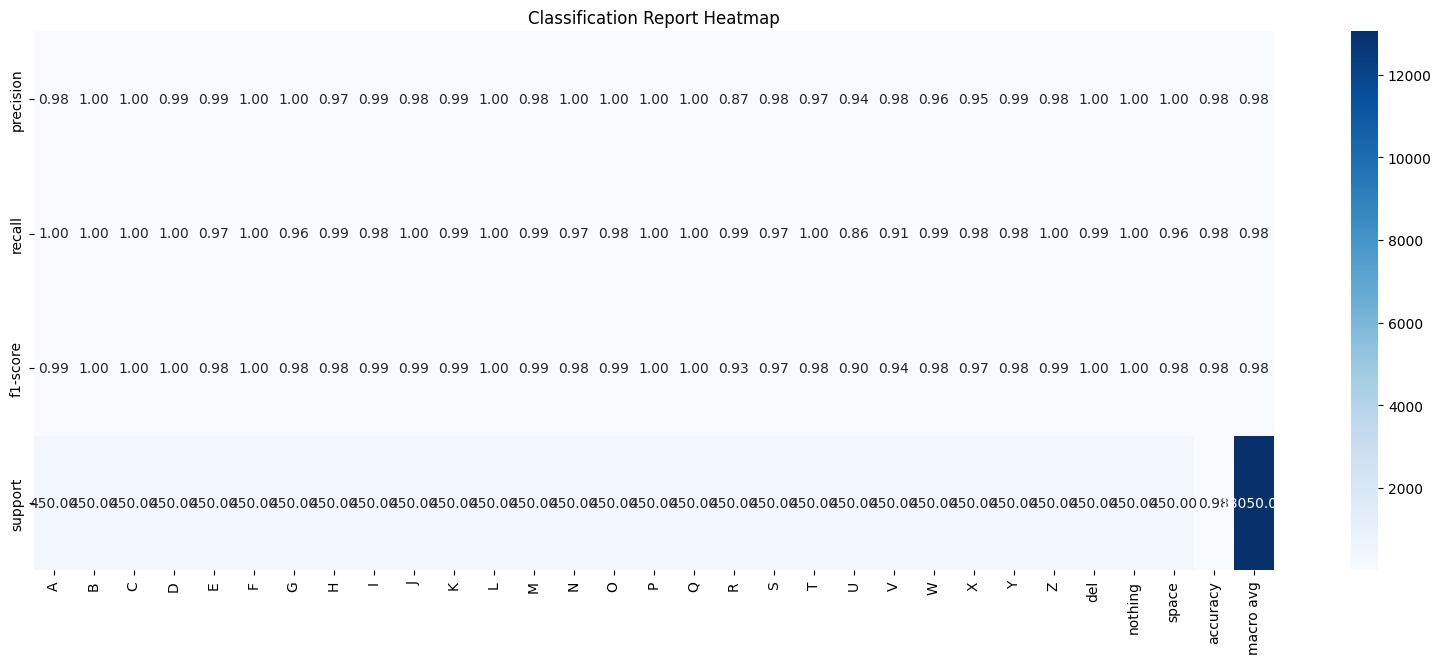

In [ ]:
import seaborn as sns
import pandas as pd

# Generate classification report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys(), output_dict=True)

# Convert report to DataFrame
report_df = pd.DataFrame(report).transpose()

# Plot classification report as a heatmap
plt.figure(figsize=(20, 7))
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')
plt.title('Classification Report Heatmap')
plt.show()


204/204 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step


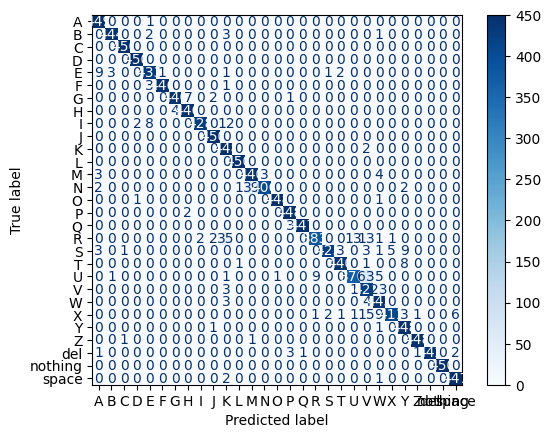

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Load the fine-tuned model
fine_tuned_model = tf.keras.models.load_model("/content/asl_vgg16_best_weights.keras")

# Predict on the test data
predictions = fine_tuned_model.predict(test_generator)

# Get the true labels from the generator
true_labels = test_generator.classes

# Compute the confusion matrix using tf.math.confusion_matrix
conf_matrix = tf.math.confusion_matrix(
    labels=true_labels,
    predictions=np.argmax(predictions, axis=1),
    num_classes=29
)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.numpy(), display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm
import numpy as np

# Define the model to extract dense features
dense_model = tf.keras.Model(inputs=fine_tuned_model.inputs, outputs=fine_tuned_model.layers[-2].output)  # Adjust layer index if needed

# Function to extract features from an image
def dense_feature_prediction(img_path):
    img = load_img(img_path, target_size=(CFG.img_height, CFG.img_width))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    dense_feature = dense_model.predict(img, verbose=0)[0]
    return dense_feature

# Collect and process data for dimensionality reduction
reduction_data_list = []  # Use a list to collect data
for label in labels:
    label_data = data_test[data_test["label"] == label][:100]  # Adjust according to your data
    reduction_data_list.append(label_data)

# Concatenate all data into a single DataFrame
reduction_data = pd.concat(reduction_data_list, ignore_index=True)

# Extract dense features for dimensionality reduction
tqdm.pandas()  # For progress bar
dense_features = reduction_data["image_path"].progress_apply(dense_feature_prediction)

dense_features_df = pd.DataFrame.from_records(dense_features.values)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=0.99, init='pca')
tsne_features = tsne.fit_transform(dense_features_df)

# Add t-SNE features to the dataframe
tsne_features_df = pd.DataFrame(tsne_features, columns=["tsne_feat_0", "tsne_feat_1"])
reduction_data = pd.concat([reduction_data, tsne_features_df], axis=1)

print(reduction_data.head())


  0%|          | 0/2900 [00:00<?, ?it/s]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2900 samples in 0.004s...
[t-SNE] Computed neighbors for 2900 samples in 0.729s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2900
[t-SNE] Computed conditional probabilities for sample 2000 / 2900
[t-SNE] Computed conditional probabilities for sample 2900 / 2900
[t-SNE] Mean sigma: 4.057868
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.458817
[t-SNE] KL divergence after 1000 iterations: 0.635034
                                          image_path label  tsne_feat_0  \
0  /content/asl-alphabet/asl_alphabet_train/asl_a...     A     8.706057   
1  /content/asl-alphabet/asl_alphabet_train/asl_a...     A     1.571646   
2  /content/asl-alphabet/asl_alphabet_train/asl_a...     A     6.321121   
3  /content/asl-alphabet/asl_alphabet_train/asl_a...     A     3.429078   
4  /content/asl-alphabet/asl_alphabet_train/asl_a...     A     6.592434   

   tsne_feat_1  
0    13.799078  
1    15.371433 

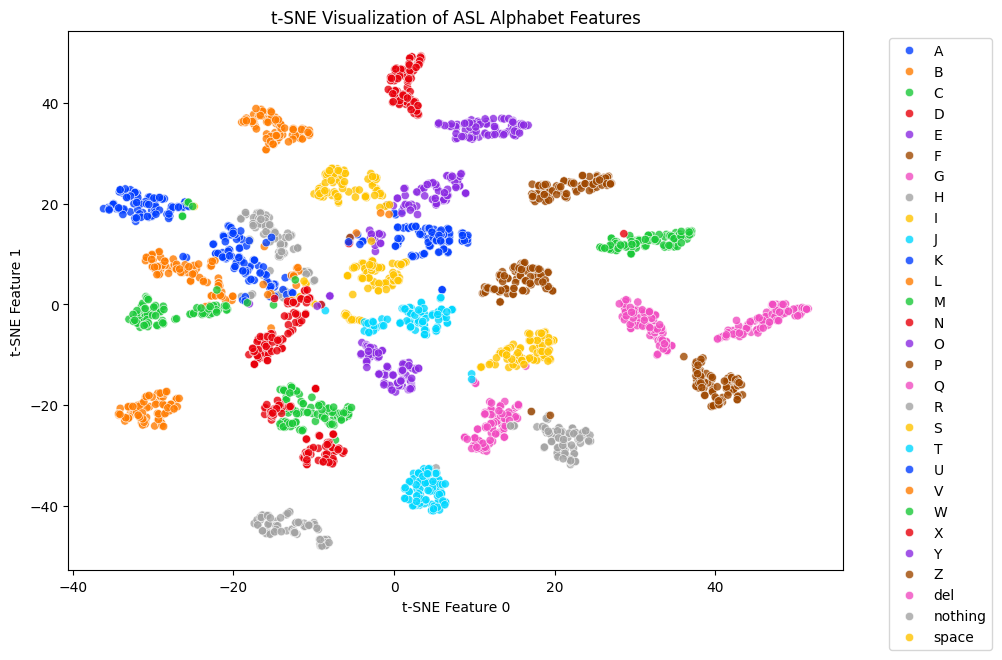

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
plt.figure(figsize=(10, 7))

# Create a scatter plot using seaborn
sns.scatterplot(
    x="tsne_feat_0",
    y="tsne_feat_1",
    hue="label",   # Color points by label (ASL letter)
    palette="bright",  # Color palette for labels
    data=reduction_data,
    legend="full",
    alpha=0.8  # Set transparency for points
)

# Add title and labels to the plot
plt.title('t-SNE Visualization of ASL Alphabet Features')
plt.xlabel('t-SNE Feature 0')
plt.ylabel('t-SNE Feature 1')

# Show the legend outside the plot for clarity
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import cv2

# Load the saved model
model = tf.keras.models.load_model('/content/asl_vgg16_best_weights.keras')

# Load and preprocess the test image
image_path = "/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/B_test.jpg"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (64, 64))  # Adjust to your model's input size
img = img / 255.0
img = np.expand_dims(img, axis=0)

# Make predictions on the image
predictions = model.predict(img)
predicted_class = np.argmax(predictions, axis=1)[0]

# Map the class index to the class label
class_labels = list(test_generator.class_indices.keys())
print(f"The predicted class is {class_labels[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
The predicted class is B


In [ ]:
import tensorflow as tf
import numpy as np
import cv2

# Load the saved model
model = tf.keras.models.load_model('/content/asl_vgg16_best_weights.keras')

# Load and preprocess the test image
image_path = "/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/G_test.jpg"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (64, 64))  # Adjust to your model's input size
img = img / 255.0
img = np.expand_dims(img, axis=0)

# Make predictions on the image
predictions = model.predict(img)
predicted_class = np.argmax(predictions, axis=1)[0]

# Map the class index to the class label
class_labels = list(test_generator.class_indices.keys())
print(f"The predicted class is {class_labels[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
The predicted class is G


In [ ]:
import tensorflow as tf
import numpy as np
import cv2

# Load the saved model
model = tf.keras.models.load_model('/content/asl_vgg16_best_weights.keras')

# Load and preprocess the test image
image_path = "/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/I_test.jpg"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (64, 64))  # Adjust to your model's input size
img = img / 255.0
img = np.expand_dims(img, axis=0)

# Make predictions on the image
predictions = model.predict(img)
predicted_class = np.argmax(predictions, axis=1)[0]

# Map the class index to the class label
class_labels = list(test_generator.class_indices.keys())
print(f"The predicted class is {class_labels[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
The predicted class is I


In [ ]:
import tensorflow as tf
import numpy as np
import cv2

# Load the saved model
model = tf.keras.models.load_model('/content/asl_vgg16_best_weights.keras')

# Load and preprocess the test image
image_path = "/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/T_test.jpg"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (64, 64))  # Adjust to your model's input size
img = img / 255.0
img = np.expand_dims(img, axis=0)

# Make predictions on the image
predictions = model.predict(img)
predicted_class = np.argmax(predictions, axis=1)[0]

# Map the class index to the class label
class_labels = list(test_generator.class_indices.keys())
print(f"The predicted class is {class_labels[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
The predicted class is T
